In [1]:
# This notebook have built from this tutorial: https://github.com/bnsreenu/python_for_microscopists/blob/master/330_Detectron2_Instance_3D_EM_Platelet.ipynb
import os

# Setup detectron2 logger
from detectron2.utils.logger import setup_logger
setup_logger()

<Logger detectron2 (DEBUG)>

In [2]:
import torch
torch.cuda.empty_cache()  # Free up unutilized memory

checking the version and if we have cuda available

In [3]:
from src.segmentation.framework_handlers.detectron2_handler import print_version_info

!nvcc --version
print_version_info()

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Aug_15_21:14:11_PDT_2021
Cuda compilation tools, release 11.4, V11.4.120
Build cuda_11.4.r11.4/compiler.30300941_0
torch:  1.9 ; cuda:  11.1
detectron2: 0.6


In [7]:
!python --version

Python 3.9.18


In [4]:
!nvidia-smi

Sun May  5 17:39:23 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.06              Driver Version: 545.23.06    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4090        On  | 00000000:C2:00.0 Off |                  Off |
| 30%   26C    P8              19W / 450W |      3MiB / 24564MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [6]:
!pip list | grep torch

torch                       1.9.0+cu111
torchaudio                  0.9.0
torchvision                 0.10.0+cu111


### Exporting the segments train and test dataset and regeister then to the detectron2 package

Remember!! when loading datasets from segments the images will be saved to the segments folder and the json coco annotations file will be save to the `saving_path` defined

In [5]:
from datetime import datetime

# Get the current date and time of the model training process
current_time = datetime.now().strftime("%d-%m-%Y_%H-%M-%S")
current_time

'05-05-2024_17-39-23'

In [6]:
model = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x"
detectron2_models_path = "/home/etaylor/code_projects/thesis/checkpoints/detectron2"
model_saving_path = os.path.join(detectron2_models_path, model, current_time)
print(model_saving_path)

/home/etaylor/code_projects/thesis/checkpoints/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/05-05-2024_17-39-23


In [7]:
from src.segmentation.framework_handlers.detectron2_handler import prepare_and_register_datasets

dataset_name_train = "etaylor/cannabis_patches_train_26-04-2024_15-44-44"
dataset_name_test = "etaylor/cannabis_patches_test_26-04-2024_15-44-44"
release_train = "v0.1"
release_test = "v0.1"
detectron2_models_path = "/home/etaylor/code_projects/thesis/checkpoints/detectron2"
model_saving_path = os.path.join(detectron2_models_path, model, current_time)

metadata_train, dataset_dicts_train, metadata_test, dataset_dicts_test = prepare_and_register_datasets(dataset_name_train, dataset_name_test, release_train, release_test)

Initializing dataset...
Preloading all samples. This may take a while...


100%|██████████| 395/395 [00:00<00:00, 441.62it/s]


Initialized dataset with 395 images.
Exporting dataset. This may take a while...


  4%|▍         | 15/395 [00:00<00:10, 37.56it/s]Skipping instance with 0 labeled pixels: IMG_0048_p7.png, instance_id: 15, category_id: 1
Skipping instance with 0 labeled pixels: IMG_0048_p8.png, instance_id: 9, category_id: 2
100%|██████████| 395/395 [00:10<00:00, 38.51it/s]


Exported to ./export_coco-instance_etaylor_cannabis_patches_train_26-04-2024_15-44-44_v0.1.json. Images in segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/v0.1
Initializing dataset...
Preloading all samples. This may take a while...


100%|██████████| 108/108 [00:00<00:00, 367.03it/s]


Initialized dataset with 108 images.
Exporting dataset. This may take a while...


100%|██████████| 108/108 [00:02<00:00, 39.89it/s]

Exported to ./export_coco-instance_etaylor_cannabis_patches_test_26-04-2024_15-44-44_v0.1.json. Images in segments/etaylor_cannabis_patches_test_26-04-2024_15-44-44/v0.1
WARNING [05/05 17:39:43 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/05 17:39:43 d2.data.datasets.coco]: Loaded 369 images in COCO format from segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/annotations/export_coco-instance_etaylor_cannabis_patches_train_26-04-2024_15-44-44_v0.1.json
WARNING [05/05 17:39:43 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/05 17:39:43 d2.data.datasets.coco]: Loaded 106 images in COCO format from segments/etaylor_cannabis_patches_test_26-04-2024_15-44-44/annotations/export_coco-instance_etaylor_cannabis_patches_test_26-04-2024_15-44-44_v0.1.json


plot train samples with annotations

In [ ]:
from src.segmentation.framework_handlers.detectron2_handler import plot_train_samples

plot_train_samples(dataset_dicts_train, metadata_train, indices=[1,2])

Define the training params and to which model to fine tune

In [8]:
from detectron2.config import get_cfg
from detectron2.engine import DefaultTrainer
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor

In [9]:
cfg = get_cfg()
cfg.OUTPUT_DIR = model_saving_path
cfg.merge_from_file(model_zoo.get_config_file(f"{model}.yaml"))
cfg.DATASETS.TRAIN = (dataset_name_train,)
cfg.DATASETS.TEST = ()
cfg.INPUT.MASK_FORMAT = "bitmask"
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(f"{model}.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 1000
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # Default is 512.
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4  # We have 4 classes.
# NOTE: this config means the number of classes, without the background. Do not use num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) #Create an instance of of DefaultTrainer with the given configuration
trainer.resume_or_load(resume=False) #Load a pretrained model if available (resume training) or start training from scratch if no pretrained model is available


[05/05 17:40:21 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (5, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (5,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (16, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (16,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (4, 256, 1, 1) 

In [10]:
trainer.train() # Start the training process

[05/05 17:40:23 d2.engine.train_loop]: Starting training from iteration 0


/home/etaylor/.conda/envs/detectron/lib/python3.9/site-packages/detectron2/data/detection_utils.py:446: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  torch.stack([torch.from_numpy(np.ascontiguousarray(x)) for x in masks])
/home/etaylor/.conda/envs/detectron/lib/python3.9/site-packages/detectron2/data/detection_utils.py:446: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or mak

[05/05 17:40:27 d2.utils.events]:  eta: 0:01:52  iter: 19  total_loss: 4.138  loss_cls: 1.598  loss_box_reg: 0.2733  loss_mask: 0.6961  loss_rpn_cls: 1.425  loss_rpn_loc: 0.1079    time: 0.1207  last_time: 0.1142  data_time: 0.0380  last_data_time: 0.0083   lr: 4.9953e-06  max_mem: 3238M
[05/05 17:40:30 d2.utils.events]:  eta: 0:01:46  iter: 39  total_loss: 3.284  loss_cls: 1.43  loss_box_reg: 0.3589  loss_mask: 0.6917  loss_rpn_cls: 0.803  loss_rpn_loc: 0.08934    time: 0.1165  last_time: 0.1219  data_time: 0.0084  last_data_time: 0.0151   lr: 9.9902e-06  max_mem: 3238M
[05/05 17:40:32 d2.utils.events]:  eta: 0:01:45  iter: 59  total_loss: 2.945  loss_cls: 1.227  loss_box_reg: 0.5063  loss_mask: 0.68  loss_rpn_cls: 0.3725  loss_rpn_loc: 0.09496    time: 0.1162  last_time: 0.1313  data_time: 0.0086  last_data_time: 0.0140   lr: 1.4985e-05  max_mem: 3375M
[05/05 17:40:35 d2.utils.events]:  eta: 0:01:45  iter: 79  total_loss: 2.626  loss_cls: 0.9877  loss_box_reg: 0.5542  loss_mask: 0.66

In [10]:
import yaml
# Save the configuration to a config.yaml file
config_yaml_path = os.path.join(cfg.OUTPUT_DIR, "config.yaml")
print(f"saving config to {config_yaml_path}")
with open(config_yaml_path, 'w') as file:
    yaml.dump(cfg, file)

saving config to /home/etaylor/code_projects/thesis/checkpoints/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/27-04-2024_12-56-46/config.yaml


In [12]:
cfg.OUTPUT_DIR

'/home/etaylor/code_projects/thesis/checkpoints/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/27-04-2024_12-56-46'

In [11]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[05/05 17:42:32 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /home/etaylor/code_projects/thesis/checkpoints/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/05-05-2024_17-39-23/model_final.pth ...


### In order to keep playing with the model use `predictor`

Plot model predictions on test set

In [ ]:
from src.segmentation.framework_handlers.detectron2_handler import plot_test_predictions

plot_test_predictions(dataset_dicts_test, metadata_test, predictor)

#### Register new test set and evaluate metrics

In [24]:
# Register new test set
from src.segmentation.framework_handlers.detectron2_handler import convert_segments_to_coco_format
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.data.datasets import register_coco_instances

dataset_name_test = "etaylor/cannabis_patches_week9_15_06_2023_3x_regular_IMG_2285"
release_test = "v0.2"

# Convert segments dataset to coco format for testing dataset
_, test_export_json_path, test_saved_images_path = convert_segments_to_coco_format(
    dataset_name=dataset_name_test, 
    release_version=release_test, 
)

register_coco_instances(dataset_name_test, {}, test_export_json_path, test_saved_images_path)

metadata_test = MetadataCatalog.get(dataset_name_test)
dataset_dicts_test = DatasetCatalog.get(dataset_name_test)

Initializing dataset...
Preloading all samples. This may take a while...


100%|██████████| 15/15 [00:03<00:00,  4.78it/s]


Initialized dataset with 15 images.
Exporting dataset. This may take a while...


100%|██████████| 15/15 [00:01<00:00, 12.75it/s]

Exported to ./export_coco-instance_etaylor_cannabis_patches_week9_15_06_2023_3x_regular_IMG_2285_v0.2.json. Images in segments/etaylor_cannabis_patches_week9_15_06_2023_3x_regular_IMG_2285/v0.2
WARNING [12/30 01:19:25 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/30 01:19:25 d2.data.datasets.coco]: Loaded 15 images in COCO format from segments/etaylor_cannabis_patches_week9_15_06_2023_3x_regular_IMG_2285/annotations/export_coco-instance_etaylor_cannabis_patches_week9_15_06_2023_3x_regular_IMG_2285_v0.2.json


Evaluate the performance of the trained model on the test dataset using the `COCOEvaluator`

In [15]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset, DatasetEvaluator
from detectron2.data import build_detection_test_loader
import json

evaluator = COCOEvaluator(dataset_name_test, output_dir=os.path.join(cfg.OUTPUT_DIR, dataset_name_test))
val_loader = build_detection_test_loader(cfg, dataset_name_test)
eval_results = inference_on_dataset(predictor.model, val_loader, evaluator)

# Check if the directory exists
output_dir = os.path.join(cfg.OUTPUT_DIR, os.path.basename(dataset_name_test))
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
    
eval_results_saving_path = os.path.join(cfg.OUTPUT_DIR, os.path.basename(dataset_name_test), "evaluation_results.json")
# Save the eval_results dictionary to a JSON file
with open(eval_results_saving_path, 'w') as file:
    json.dump(eval_results, file, indent=4)

WARNING [05/05 17:46:59 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/05 17:46:59 d2.data.datasets.coco]: Loaded 106 images in COCO format from segments/etaylor_cannabis_patches_test_26-04-2024_15-44-44/annotations/export_coco-instance_etaylor_cannabis_patches_test_26-04-2024_15-44-44_v0.1.json
[05/05 17:46:59 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/05 17:46:59 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[05/05 17:46:59 d2.data.common]: Serializing 106 elements to byte tensors and concatenating them all ...
[05/05 17:46:59 d2.data.common]: Serialized dataset takes 0.22 MiB
[05/05 17:46:59 d2.evaluation.evaluator]: Start inference on 106 batches


[05/05 17:47:00 d2.evaluation.evaluator]: Inference done 11/106. Dataloading: 0.0010 s/iter. Inference: 0.0369 s/iter. Eval: 0.0088 s/iter. Total: 0.0467 s/iter. ETA=0:00:04
[05/05 17:47:04 d2.evaluation.evaluator]: Total inference time: 0:00:04.775814 (0.047285 s / iter per device, on 1 devices)
[05/05 17:47:04 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:03 (0.036493 s / iter per device, on 1 devices)
[05/05 17:47:04 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[05/05 17:47:04 d2.evaluation.coco_evaluation]: Saving results to /home/etaylor/code_projects/thesis/checkpoints/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/05-05-2024_17-39-23/etaylor/cannabis_patches_test_26-04-2024_15-44-44/coco_instances_results.json
[05/05 17:47:04 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
[05/05 17:47:04 d2.evaluation.fast_e

#### Segment images and save object level information into a csv file.



In [11]:
from src.segmentation.framework_handlers.detectron2_handler import extract_object_info_to_csv

dataset_directory = "/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_week8_07_06_2023_3x_regular_IMG_1753" 
input_images_directory = os.path.join(dataset_directory, "v0.1")
csv_file_name = "detected_objects.csv"
output_csv_path = os.path.join(dataset_directory,csv_file_name)

extract_object_info_to_csv(input_images_directory, output_csv_path, predictor, metadata_train)

'Object-level information saved to CSV file at /home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_week8_07_06_2023_3x_regular_IMG_1753/detected_objects.csv'

In [ ]:
from src.segmentation.framework_handlers.detectron2_handler import plot_class_statistics

plot_class_statistics(output_csv_path, metadata_train)

/tmp/ipykernel_24632/3811209441.py:19: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="Class Name", y="Object Number", data=avg_objects_per_class, ci=None, order=class_names)


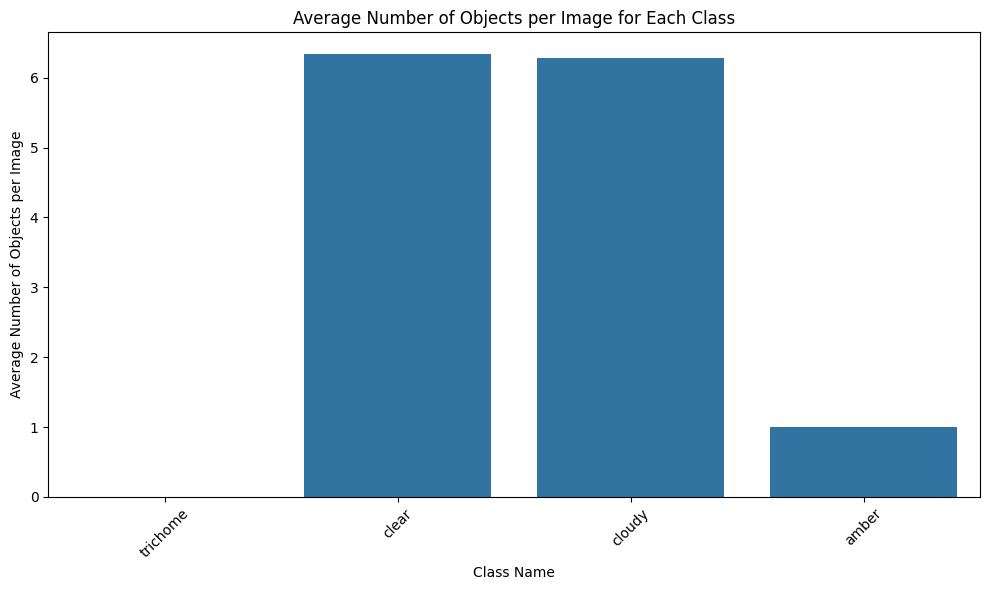

/tmp/ipykernel_24632/3811209441.py:33: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="Class Name", y="Area", data=avg_area_per_class, ci=None, order=class_names)


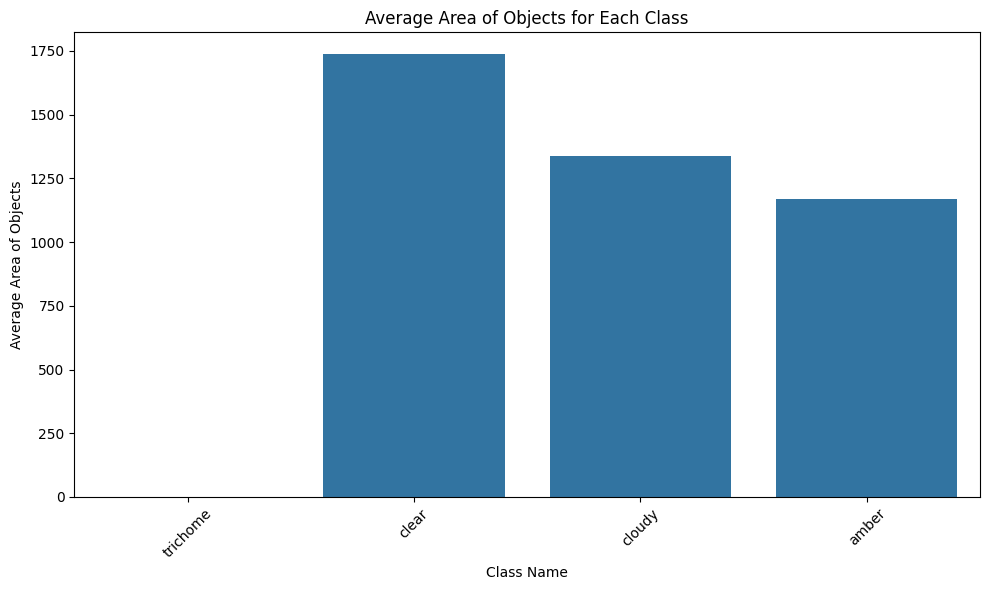

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the CSV file into a pandas DataFrame
df = pd.read_csv(output_csv_path)

# Get class names from train_metadata.thing_classes
class_names = metadata_train.thing_classes

# Group the data by both "File Name" and "Class Name" and calculate the average number of objects per image for each class
# first group the data by both "File Name" and "Class Name" and count the number of objects within each group.
#Then, group the data by "Class Name" only and calculate the mean of the counts, which gives us the average number of objects per image for each class.
avg_objects_per_class = df.groupby(["File Name", "Class Name"])["Object Number"].count().reset_index()
avg_objects_per_class = avg_objects_per_class.groupby("Class Name")["Object Number"].mean().reset_index()

# Plot: Average number of objects per image for each class
plt.figure(figsize=(10, 6))
sns.barplot(x="Class Name", y="Object Number", data=avg_objects_per_class, ci=None, order=class_names)
plt.xticks(rotation=45)
plt.xlabel("Class Name")
plt.ylabel("Average Number of Objects per Image")
plt.title("Average Number of Objects per Image for Each Class")
plt.tight_layout()
plt.show()


# Group the data by class and calculate the average area of objects for each class
avg_area_per_class = df.groupby("Class Name")["Area"].mean().reset_index()

# Plot: Average area of objects for each class
plt.figure(figsize=(10, 6))
sns.barplot(x="Class Name", y="Area", data=avg_area_per_class, ci=None, order=class_names)
plt.xticks(rotation=45)
plt.xlabel("Class Name")
plt.ylabel("Average Area of Objects")
plt.title("Average Area of Objects for Each Class")
plt.tight_layout()
plt.show()
